In [2]:
pip install gym stable-baselines3[extra] numpy pandas scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 3.1 MB/s eta 0:00:00


In [3]:
pip install "shimmy>=2.0" gym==0.25.2 gymnasium


In [4]:
# ============================
# Colab Setup & Imports
# ============================
# If you're on Google Colab, install osmium (optional)
!pip -q install osmium

from google.colab import drive
import os
import time
import math
import re
import random
import numpy as np
import pandas as pd
import datetime
import requests

# Optional import (not required for TomTom)
import osmium as osm  # noqa: F401

# If you haven’t already in a previous cell, set your key like this:
# import os
# os.environ["OPENWEATHER_API_KEY"] = "596eadfb2fd863480d863b7062bd2e8f"

# ============================
# 0. FILE PATHS
# ============================
# Mount Google Drive
drive.mount('/content/drive')

# Paths to your files in Drive
demand_path = "/content/drive/MyDrive/synthetic_demand_data.csv"
fleet_path  = "/content/drive/MyDrive/synthetic_fleet_with_coords (1).csv"

# Read CSVs
demand_df = pd.read_csv(demand_path)
fleet_df  = pd.read_csv(fleet_path)

# ============================
# 1. LOAD DEMAND DATA FROM CSV
#    Expected cols: demand_id, time, zone, lat, lon, demand_size_kg
# ============================

# Check required columns
required_demand_cols = ["time", "zone", "lat", "lon", "demand_size_kg"]
missing_demand = [c for c in required_demand_cols if c not in demand_df.columns]
if missing_demand:
    raise ValueError(f"Demand CSV is missing required columns: {missing_demand}")

# Parse time column
demand_df["time"] = pd.to_datetime(demand_df["time"], errors="coerce")

# Ensure numeric types for lat/lon/size
for c in ["lat", "lon", "demand_size_kg"]:
    demand_df[c] = pd.to_numeric(demand_df[c], errors="coerce")

print("Demand sample:\n", demand_df.head())

# ============================
# 2. LOAD FLEET DATA FROM CSV
#    Normalize to: vehicle_id, capacity, lat, lon, availability
# ============================

required_fleet_cols_before = ["vehicle_id", "capacity_kg", "latitude", "longitude"]
missing_fleet = [c for c in required_fleet_cols_before if c not in fleet_df.columns]
if missing_fleet:
    raise ValueError(f"Fleet CSV is missing required columns: {missing_fleet}")

fleet_df = fleet_df.rename(columns={
    "capacity_kg": "capacity",
    "latitude": "lat",
    "longitude": "lon"
})

if "availability" not in fleet_df.columns:
    fleet_df["availability"] = 1

for c in ["capacity", "lat", "lon", "availability"]:
    fleet_df[c] = pd.to_numeric(fleet_df[c], errors="coerce")

print("\nFleet sample (normalized):\n", fleet_df.head())

# ============================
# 3. LIVE TRAFFIC FROM TOMTOM FLOW
# ============================

TOMTOM_API_KEY = os.environ.get("TOMTOM_API_KEY", "8tnvwDhRN7nFEDHgC78NtgP1bmQye9vp")
if not TOMTOM_API_KEY or TOMTOM_API_KEY.startswith("<"):
    raise RuntimeError(
        "TomTom API key not set. Set os.environ['TOMTOM_API_KEY'] = 'YOUR_TOMTOM_KEY'."
    )

TOMTOM_FLOW_URL = "https://api.tomtom.com/traffic/services/4/flowSegmentData/absolute/10/json"

POLL_INTERVAL_SEC = 60
POLL_CYCLES = 5

def get_tomtom_speed_kmh(lat, lon, retries=2, pause_sec=0.5):
    params = {"point": f"{lat},{lon}", "key": TOMTOM_API_KEY}
    attempt = 0
    while True:
        try:
            resp = requests.get(TOMTOM_FLOW_URL, params=params, timeout=15)
            if resp.status_code in (429, 500, 502, 503, 504):
                if attempt < retries:
                    attempt += 1
                    time.sleep(pause_sec * (attempt + 1))
                    continue
                resp.raise_for_status()
            resp.raise_for_status()
            data = resp.json()
            fsd = (data or {}).get("flowSegmentData", {}) or {}
            cur = fsd.get("currentSpeed")
            if isinstance(cur, (int, float)) and cur > 0:
                return float(cur)
            ffs = fsd.get("freeFlowSpeed")
            if isinstance(ffs, (int, float)) and ffs > 0:
                return float(ffs)
            return 30.0
        except requests.RequestException:
            if attempt < retries:
                attempt += 1
                time.sleep(pause_sec * (attempt + 1))
                continue
            return 30.0

def batch_get_tomtom_speeds(coords, pause_sec=0.1):
    rounded = [(round(float(lat), 5), round(float(lon), 5)) for (lat, lon) in coords]
    unique = list(dict.fromkeys(rounded))

    speed_map = {}
    for (rlat, rlon) in unique:
        speed_map[(rlat, rlon)] = get_tomtom_speed_kmh(rlat, rlon)
        time.sleep(pause_sec)

    result = {}
    for (lat, lon), (rlat, rlon) in zip(coords, rounded):
        result[(float(lat), float(lon))] = speed_map[(rlat, rlon)]
    return result

def refresh_live_traffic(demand_df: pd.DataFrame, poll_cycles: int = 1, interval_sec: int = 60):
    coords = [(float(r.lat), float(r.lon)) for _, r in demand_df.iterrows()]
    for i in range(1, poll_cycles + 1):
        tt_speed_by_coord = batch_get_tomtom_speeds(coords, pause_sec=0.1)
        demand_df["traffic_speed_kmh"] = [
            tt_speed_by_coord[(float(r.lat), float(r.lon))] for _, r in demand_df.iterrows()
        ]
        print(f"\n[{datetime.datetime.now()}] TomTom speeds refreshed (cycle {i}/{poll_cycles}).")
        print(demand_df[["lat", "lon", "traffic_speed_kmh"]])
        if i < poll_cycles:
            time.sleep(interval_sec)

# ============================
# 4. LIVE WEATHER FROM OPENWEATHER
# ============================

# ✅ FIX 1: Read the **env var name**, not the key value
OPENWEATHER_API_KEY = os.environ.get("OPENWEATHER_API_KEY", "596eadfb2fd863480d863b7062bd2e8f")
if not OPENWEATHER_API_KEY or OPENWEATHER_API_KEY.startswith("<") or len(OPENWEATHER_API_KEY.strip()) == 0:
    raise RuntimeError(
        "OpenWeather API key not set. Set os.environ['OPENWEATHER_API_KEY'] = 'YOUR_OPENWEATHER_API_KEY'."
    )

# (Optional) quick sanity check without revealing your whole key
print("OpenWeather key loaded (last 4): ****" + OPENWEATHER_API_KEY[-4:])

OPENWEATHER_URL = "https://api.openweathermap.org/data/2.5/weather"

def get_openweather(lat, lon, retries=2, pause_sec=0.5):
    """
    Query OpenWeather current weather for (lat, lon).
    Returns: description, temp_c, humidity, wind_speed_ms, precip_mm_hr
    """
    # ✅ FIX 2: Use the env var in the request, not a hardcoded key
    params = {
        "lat": float(lat),
        "lon": float(lon),
        "appid": OPENWEATHER_API_KEY,
        "units": "metric",
    }
    attempt = 0
    while True:
        try:
            resp = requests.get(OPENWEATHER_URL, params=params, timeout=15)
            if resp.status_code in (429, 500, 502, 503, 504):
                if attempt < retries:
                    attempt += 1
                    time.sleep(pause_sec * (attempt + 1))
                    continue
                resp.raise_for_status()
            resp.raise_for_status()
            data = resp.json() or {}

            weather_list = data.get("weather") or []
            description = (weather_list[0].get("description") if weather_list else "") or ""
            main = data.get("main") or {}
            wind = data.get("wind") or {}
            rain = data.get("rain") or {}
            snow = data.get("snow") or {}

            temp_c = float(main.get("temp")) if isinstance(main.get("temp"), (int, float)) else np.nan
            humidity = int(main.get("humidity")) if isinstance(main.get("humidity"), (int, float)) else np.nan
            wind_ms = float(wind.get("speed")) if isinstance(wind.get("speed"), (int, float)) else np.nan

            precip_1h = np.nan
            if isinstance(rain.get("1h"), (int, float)):
                precip_1h = float(rain["1h"])
            elif isinstance(snow.get("1h"), (int, float)):
                precip_1h = float(snow["1h"])

            return {
                "description": str(description).lower(),
                "temp_c": temp_c,
                "humidity": humidity,
                "wind_speed_ms": wind_ms,
                "precip_mm_hr": precip_1h if not np.isnan(precip_1h) else 0.0,
            }
        except requests.RequestException:
            if attempt < retries:
                attempt += 1
                time.sleep(pause_sec * (attempt + 1))
                continue
            return {
                "description": "",
                "temp_c": np.nan,
                "humidity": np.nan,
                "wind_speed_ms": np.nan,
                "precip_mm_hr": 0.0,
            }

def batch_get_openweather(coords, pause_sec=0.1):
    rounded = [(round(float(lat), 5), round(float(lon), 5)) for (lat, lon) in coords]
    unique = list(dict.fromkeys(rounded))

    weather_map = {}
    for (rlat, rlon) in unique:
        weather_map[(rlat, rlon)] = get_openweather(rlat, rlon)
        time.sleep(pause_sec)

    result = {}
    for (lat, lon), (rlat, rlon) in zip(coords, rounded):
        result[(float(lat), float(lon))] = weather_map[(rlat, rlon)]
    return result

def compute_weather_factor(desc: str, precip_mm_hr: float) -> float:
    d = (desc or "").lower()
    if precip_mm_hr and precip_mm_hr > 0:
        return 1.25
    if any(k in d for k in ["thunderstorm", "snow", "sleet"]):
        return 1.3
    if "rain" in d or "drizzle" in d:
        return 1.2
    if "mist" in d or "fog" in d or "haze" in d or "smoke" in d:
        return 1.1
    return 1.0

def refresh_live_weather(demand_df: pd.DataFrame, poll_cycles: int = 1, interval_sec: int = 60):
    coords = [(float(r.lat), float(r.lon)) for _, r in demand_df.iterrows()]
    for i in range(1, poll_cycles + 1):
        ow_by_coord = batch_get_openweather(coords, pause_sec=0.1)

        weather_desc = []
        temp_c_list = []
        humidity_list = []
        wind_ms_list = []
        precip_list = []
        factor_list = []

        for _, r in demand_df.iterrows():
            w = ow_by_coord[(float(r.lat), float(r.lon))]
            desc = w["description"]
            temp_c = w["temp_c"]
            humidity = w["humidity"]
            wind_ms = w["wind_speed_ms"]
            precip = w["precip_mm_hr"]
            factor = compute_weather_factor(desc, precip)

            weather_desc.append(desc)
            temp_c_list.append(temp_c)
            humidity_list.append(humidity)
            wind_ms_list.append(wind_ms)
            precip_list.append(precip)
            factor_list.append(factor)

        demand_df["weather_description"] = weather_desc
        demand_df["temp_c"] = temp_c_list
        demand_df["humidity"] = humidity_list
        demand_df["wind_speed_ms"] = wind_ms_list
        demand_df["precip_mm_hr"] = precip_list
        demand_df["weather_factor"] = factor_list

        print(f"\n[{datetime.datetime.now()}] OpenWeather refreshed (cycle {i}/{poll_cycles}).")
        print(demand_df[["lat", "lon", "weather_description", "temp_c", "humidity", "wind_speed_ms", "precip_mm_hr", "weather_factor"]].head())

        if i < poll_cycles:
            time.sleep(interval_sec)

# --- First fetches happen here ---
refresh_live_traffic(demand_df, poll_cycles=POLL_CYCLES, interval_sec=POLL_INTERVAL_SEC)
refresh_live_weather(demand_df, poll_cycles=POLL_CYCLES, interval_sec=POLL_INTERVAL_SEC)

# ============================
# 5. STATE VECTOR CREATION
# ============================

state_vectors = []

for _, vehicle in fleet_df.iterrows():
    vlat = float(vehicle["lat"])
    vlon = float(vehicle["lon"])
    vcap = float(vehicle["capacity"])
    vavail = float(vehicle["availability"])

    for _, demand in demand_df.iterrows():
        dlat = float(demand["lat"])
        dlon = float(demand["lon"])
        dsize = float(demand["demand_size_kg"])
        base_speed = float(demand["traffic_speed_kmh"]) if pd.notnull(demand.get("traffic_speed_kmh", np.nan)) else 0.0

        wfactor = float(demand.get("weather_factor", 1.0)) if pd.notnull(demand.get("weather_factor", np.nan)) else 1.0

        # Euclidean distance on degrees (rough; consider haversine later)
        distance = np.linalg.norm([vlat - dlat, vlon - dlon])

        adjusted_speed = base_speed * wfactor
        speed_km_per_min = (adjusted_speed / 60.0) if adjusted_speed > 0 else 0.0
        eta = distance / (speed_km_per_min + 1e-6)

        state = [
            vcap,
            vavail,
            dsize,
            adjusted_speed,
            eta,
            distance,
        ]
        state_vectors.append(state)

state_matrix = np.array(state_vectors, dtype=float)

print("\nState Matrix Shape:", state_matrix.shape)
if state_matrix.size > 0:
    print("Sample State Vector (first row):\n", state_matrix[0])

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 16.5 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Mounted at /content/drive
Demand sample:
                  time          zone      lat     lon  demand_size_kg
0 2025-08-28 00:41:00  Yeshwanthpur  13.0186  77.556             149
1 2025-08-28 00:18:00  Yeshwanthpur  13.0186  77.556              90
2 2025-08-28 00:35:00  Yeshwanthpur  13.0186  77.556             146
3 2025-08-28 00:36:00  Yeshwanthpur  13.0186  77.556              79
4 2025-08-28 00:48:00  Yeshwanthpur  13.0186  77.556             125

Fleet sample (normalized):
   vehicle_id pickup_location  capacity availability_time_ist      lat  \
0       V001    Yeshwanthpur       500   2025-08-28 09:23:00  13.0285   
1       V002      Whitefield       500   2025-08-28 17:05:00  12.9698   
2       V003     Koramangala      1500   2025-08-28 17:58:00  12.9279   
3       V004     Koramangala      1000   2025-08-28 15:18:00  12.9279   
4       V005    Marathahalli      1000   2025-08-28 13:09:00  12.9560   

       lon  availability  
0  77.5406             1  
1  77.7499            

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



[2025-09-04 22:04:42.318246] TomTom speeds refreshed (cycle 1/5).
          lat      lon  traffic_speed_kmh
0     13.0186  77.5560               20.0
1     13.0186  77.5560               20.0
2     13.0186  77.5560               20.0
3     13.0186  77.5560               20.0
4     13.0186  77.5560               20.0
...       ...      ...                ...
1433  12.8452  77.6602               27.0
1434  12.8452  77.6602               27.0
1435  12.8452  77.6602               27.0
1436  12.8452  77.6602               27.0
1437  12.8452  77.6602               27.0

[1438 rows x 3 columns]


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



[2025-09-04 22:05:43.862357] TomTom speeds refreshed (cycle 2/5).
          lat      lon  traffic_speed_kmh
0     13.0186  77.5560               20.0
1     13.0186  77.5560               20.0
2     13.0186  77.5560               20.0
3     13.0186  77.5560               20.0
4     13.0186  77.5560               20.0
...       ...      ...                ...
1433  12.8452  77.6602               27.0
1434  12.8452  77.6602               27.0
1435  12.8452  77.6602               27.0
1436  12.8452  77.6602               27.0
1437  12.8452  77.6602               27.0

[1438 rows x 3 columns]


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



[2025-09-04 22:06:45.411495] TomTom speeds refreshed (cycle 3/5).
          lat      lon  traffic_speed_kmh
0     13.0186  77.5560               20.0
1     13.0186  77.5560               20.0
2     13.0186  77.5560               20.0
3     13.0186  77.5560               20.0
4     13.0186  77.5560               20.0
...       ...      ...                ...
1433  12.8452  77.6602               27.0
1434  12.8452  77.6602               27.0
1435  12.8452  77.6602               27.0
1436  12.8452  77.6602               27.0
1437  12.8452  77.6602               27.0

[1438 rows x 3 columns]


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



[2025-09-04 22:07:46.901836] TomTom speeds refreshed (cycle 4/5).
          lat      lon  traffic_speed_kmh
0     13.0186  77.5560               20.0
1     13.0186  77.5560               20.0
2     13.0186  77.5560               20.0
3     13.0186  77.5560               20.0
4     13.0186  77.5560               20.0
...       ...      ...                ...
1433  12.8452  77.6602               27.0
1434  12.8452  77.6602               27.0
1435  12.8452  77.6602               27.0
1436  12.8452  77.6602               27.0
1437  12.8452  77.6602               27.0

[1438 rows x 3 columns]


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



[2025-09-04 22:08:48.366365] TomTom speeds refreshed (cycle 5/5).
          lat      lon  traffic_speed_kmh
0     13.0186  77.5560               20.0
1     13.0186  77.5560               20.0
2     13.0186  77.5560               20.0
3     13.0186  77.5560               20.0
4     13.0186  77.5560               20.0
...       ...      ...                ...
1433  12.8452  77.6602               27.0
1434  12.8452  77.6602               27.0
1435  12.8452  77.6602               27.0
1436  12.8452  77.6602               27.0
1437  12.8452  77.6602               27.0

[1438 rows x 3 columns]


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



[2025-09-04 22:08:49.775697] OpenWeather refreshed (cycle 1/5).
       lat     lon weather_description  temp_c  humidity  wind_speed_ms  \
0  13.0186  77.556       broken clouds   20.44        91           3.09   
1  13.0186  77.556       broken clouds   20.44        91           3.09   
2  13.0186  77.556       broken clouds   20.44        91           3.09   
3  13.0186  77.556       broken clouds   20.44        91           3.09   
4  13.0186  77.556       broken clouds   20.44        91           3.09   

   precip_mm_hr  weather_factor  
0           0.0             1.0  
1           0.0             1.0  
2           0.0             1.0  
3           0.0             1.0  
4           0.0             1.0  


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



[2025-09-04 22:09:51.274041] OpenWeather refreshed (cycle 2/5).
       lat     lon weather_description  temp_c  humidity  wind_speed_ms  \
0  13.0186  77.556       broken clouds   20.44        91           3.09   
1  13.0186  77.556       broken clouds   20.44        91           3.09   
2  13.0186  77.556       broken clouds   20.44        91           3.09   
3  13.0186  77.556       broken clouds   20.44        91           3.09   
4  13.0186  77.556       broken clouds   20.44        91           3.09   

   precip_mm_hr  weather_factor  
0           0.0             1.0  
1           0.0             1.0  
2           0.0             1.0  
3           0.0             1.0  
4           0.0             1.0  


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



[2025-09-04 22:10:52.771209] OpenWeather refreshed (cycle 3/5).
       lat     lon weather_description  temp_c  humidity  wind_speed_ms  \
0  13.0186  77.556       broken clouds   20.44        91           3.09   
1  13.0186  77.556       broken clouds   20.44        91           3.09   
2  13.0186  77.556       broken clouds   20.44        91           3.09   
3  13.0186  77.556       broken clouds   20.44        91           3.09   
4  13.0186  77.556       broken clouds   20.44        91           3.09   

   precip_mm_hr  weather_factor  
0           0.0             1.0  
1           0.0             1.0  
2           0.0             1.0  
3           0.0             1.0  
4           0.0             1.0  


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



[2025-09-04 22:11:54.251211] OpenWeather refreshed (cycle 4/5).
       lat     lon weather_description  temp_c  humidity  wind_speed_ms  \
0  13.0186  77.556       broken clouds   20.44        91           3.09   
1  13.0186  77.556       broken clouds   20.44        91           3.09   
2  13.0186  77.556       broken clouds   20.44        91           3.09   
3  13.0186  77.556       broken clouds   20.44        91           3.09   
4  13.0186  77.556       broken clouds   20.44        91           3.09   

   precip_mm_hr  weather_factor  
0           0.0             1.0  
1           0.0             1.0  
2           0.0             1.0  
3           0.0             1.0  
4           0.0             1.0  


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



[2025-09-04 22:12:55.735586] OpenWeather refreshed (cycle 5/5).
       lat     lon weather_description  temp_c  humidity  wind_speed_ms  \
0  13.0186  77.556       broken clouds   20.44        91           3.09   
1  13.0186  77.556       broken clouds   20.44        91           3.09   
2  13.0186  77.556       broken clouds   20.44        91           3.09   
3  13.0186  77.556       broken clouds   20.44        91           3.09   
4  13.0186  77.556       broken clouds   20.44        91           3.09   

   precip_mm_hr  weather_factor  
0           0.0             1.0  
1           0.0             1.0  
2           0.0             1.0  
3           0.0             1.0  
4           0.0             1.0  


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag


State Matrix Shape: (28760, 6)
Sample State Vector (first row):
 [5.00000000e+02 1.00000000e+00 1.49000000e+02 2.00000000e+01
 5.49227813e-02 1.83076487e-02]


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


=== Live Fleet Optimization — Cycle 4/5 ===
   total_reward  avg_eta_min  avg_distance_km  avg_speed_kmh  \
0 -11000.171115      9.23717          4.14858      30.480529   

   avg_weather_factor  feasibility_rate  
0                 1.0               1.0  

Sample assignments (first 10):


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,d_idx,v_idx,reward,eta_min,dist_km,speed_kmh,wfactor,capacity,dsize,availability
0,0,0,-4.757146,5.996432,1.998811,20.0,1.0,500.0,149.0,1
1,1,0,-4.757146,5.996432,1.998811,20.0,1.0,500.0,90.0,1
2,2,0,-4.757146,5.996432,1.998811,20.0,1.0,500.0,146.0,1
3,3,5,-16.024533,20.080666,6.693555,20.0,1.0,1000.0,79.0,1
4,4,0,-4.757146,5.996432,1.998811,20.0,1.0,500.0,125.0,1
5,5,5,-16.024533,20.080666,6.693555,20.0,1.0,1000.0,57.0,1
6,6,17,0.075434,0.000636,0.000403,38.0,1.0,5000.0,155.0,1
7,7,17,0.075434,0.000636,0.000403,38.0,1.0,5000.0,78.0,1
8,8,17,0.075434,0.000636,0.000403,38.0,1.0,5000.0,110.0,1
9,9,17,0.075434,0.000636,0.000403,38.0,1.0,5000.0,78.0,1


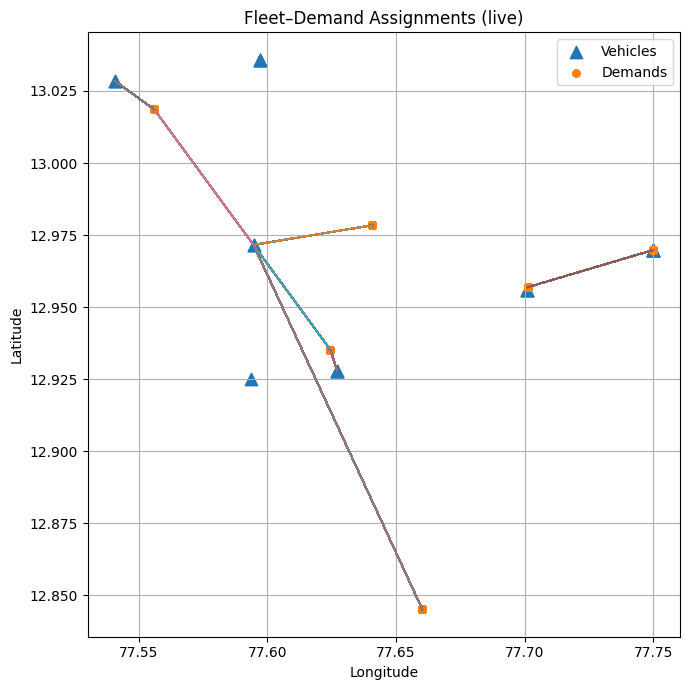

In [ ]:
# ============================================
# Live RL Fleet Assignment (every 3 minutes)
# ============================================
#!pip -q install "stable-baselines3==1.8.0" "gym==0.26.2" "shimmy>=2.0" scikit-learn matplotlib


import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from gym import spaces
import gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from sklearn.preprocessing import StandardScaler

# ---------- Helpers ----------

def haversine_km(lat1, lon1, lat2, lon2):
    """Great-circle distance (km)."""
    R = 6371.0088
    p1 = np.radians(lat1)
    p2 = np.radians(lat2)
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat/2.0)**2 + np.cos(p1)*np.cos(p2)*np.sin(dlon/2.0)**2
    return 2 * R * np.arcsin(np.sqrt(a + 1e-15))

def build_pair_features_live(fleet_df: pd.DataFrame, demand_df: pd.DataFrame):
    """
    Build pair_features with ONLY real/live columns from your frames.
    Features per pair [capacity, availability, demand_size, speed_kmh, weather_factor, eta_min, distance_km]
    - traffic_speed_kmh: from TomTom refresh
    - weather_factor: from your compute_weather_factor / OpenWeather refresh
    """
    # sanity: ensure required cols exist
    req_demand = ["lat","lon","demand_size_kg","traffic_speed_kmh","weather_factor"]
    for c in req_demand:
        if c not in demand_df.columns:
            raise ValueError(f"demand_df missing required column: {c}")
    req_fleet = ["capacity","availability","lat","lon"]
    for c in req_fleet:
        if c not in fleet_df.columns:
            raise ValueError(f"fleet_df missing required column: {c}")

    V = len(fleet_df)
    D = len(demand_df)
    feat_dim = 7
    pair_features = np.zeros((D, V, feat_dim), dtype=np.float32)

    for d_idx, d in demand_df.reset_index(drop=True).iterrows():
        dlat, dlon = float(d.lat), float(d.lon)
        dsize = float(d.demand_size_kg)
        speed = float(d.traffic_speed_kmh) if pd.notnull(d.traffic_speed_kmh) else 0.0
        wfactor = float(d.weather_factor) if pd.notnull(d.weather_factor) else 1.0

        # guardrails
        speed = max(speed, 0.0)
        wfactor = max(wfactor, 1.0)  # your function yields >=1.0 for worse weather

        for v_idx, v in fleet_df.reset_index(drop=True).iterrows():
            vlat, vlon = float(v.lat), float(v.lon)
            cap = float(v.capacity)
            avail = float(v.get("availability", 1))

            dist_km = haversine_km(vlat, vlon, dlat, dlon)
            # Effective travel speed preference: keep ETA in minutes
            adj_speed = speed / max(wfactor, 1e-6)  # worse weather -> slower effective speed
            eta_min = (dist_km / max(adj_speed, 1e-3)) * 60.0

            pair_features[d_idx, v_idx] = np.array([
                cap, avail, dsize, speed, wfactor, eta_min, dist_km
            ], dtype=np.float32)

    return pair_features

class FleetAssignmentEnv(gym.Env):
    """
    Env streams through demands; action = choose vehicle index.
    Observation = all vehicle-pair features for current demand (flattened).
    Reward encourages: minimal distance, short ETA, higher speed, moderate weather.
    """
    metadata = {'render.modes': ['human']}
    def __init__(self, pair_features: np.ndarray, vehicle_capacities: np.ndarray, demand_sizes: np.ndarray, normalize=True):
        super().__init__()
        self.pair_features = pair_features
        self.vehicle_capacities = np.array(vehicle_capacities, dtype=np.float32)
        self.demand_sizes = np.array(demand_sizes, dtype=np.float32)

        self.num_demands, self.num_vehicles, self.feat_dim = self.pair_features.shape

        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf,
            shape=(self.num_vehicles * self.feat_dim,),
            dtype=np.float32
        )
        self.action_space = spaces.Discrete(self.num_vehicles)

        self.normalize = normalize
        if normalize:
            self.scaler = StandardScaler()
            self.scaler.fit(self.pair_features.reshape(-1, self.feat_dim))
        else:
            self.scaler = None

        self.current_idx = 0
        self.assignments = []

    def reset(self):
        self.current_idx = 0
        self.assignments = []
        return self._get_obs()

    def _get_obs(self):
        feats = self.pair_features[self.current_idx]  # (V, F)
        if self.normalize:
            feats = self.scaler.transform(feats)
        return feats.flatten().astype(np.float32)

    def step(self, action):
        v_idx = int(action)
        d_idx = self.current_idx
        pf = self.pair_features[d_idx, v_idx]  # [cap, avail, dsize, speed, wfactor, eta, dist]
        cap, avail, dsize, speed, wfactor, eta, dist = pf.tolist()

        # Reward shaping
        # - minimize ETA & distance
        # - prefer higher traffic speed
        # - prefer moderate weather (wfactor close to 1)
        r = 0.0
        r -= 0.7 * eta                        # shorter ETA better
        r -= 0.3 * dist                       # closer better
        r += 0.1 * (speed / 50.0)             # scale: modest positive for higher speed
        r -= 5.0 * max(0.0, wfactor - 1.0)    # penalty for worse weather (>1 means worse in your function)

        # Feasibility penalties
        if cap < dsize:
            r -= 100.0
        if int(avail) == 0:
            r -= 10.0

        self.assignments.append((d_idx, v_idx, r, eta, dist, speed, wfactor, cap, dsize, int(avail)))

        self.current_idx += 1
        done = self.current_idx >= self.num_demands
        obs = np.zeros(self.observation_space.shape, dtype=np.float32) if done else self._get_obs()
        info = {}
        return obs, float(r), done, info

    def render(self, mode='human'):
        tail = self.assignments[-5:]
        print("Recent assignments:", tail)

# ---------- Policy lifecycle helpers ----------

MODEL_PATH = "/content/fleet_assign_ppo.zip"
policy_model = None

def get_or_create_model(env):
    global policy_model
    if policy_model is None:
        vec_env = DummyVecEnv([lambda: env])
        policy_model = PPO("MlpPolicy", vec_env, verbose=0, n_steps=64, batch_size=64, ent_coef=0.01)
    else:
        # If model exists, attach new env (shape may change with new live data)
        policy_model.set_env(DummyVecEnv([lambda: env]))
    return policy_model

def train_step(model, timesteps=2000):
    model.learn(total_timesteps=int(timesteps))

def eval_policy_greedy(env, model):
    obs = env.reset()
    done = False
    total_reward = 0.0
    chosen = []
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, r, done, _ = env.step(action)
        total_reward += float(r)
        chosen.append(env.assignments[-1])  # last assignment tuple
    # Metrics
    assn = pd.DataFrame(chosen, columns=[
        "d_idx","v_idx","reward","eta_min","dist_km","speed_kmh","wfactor","capacity","dsize","availability"
    ])
    feasible = (assn["capacity"] >= assn["dsize"]) & (assn["availability"] == 1)
    avg_eta = assn["eta_min"].mean() if len(assn) else np.nan
    avg_dist = assn["dist_km"].mean() if len(assn) else np.nan
    avg_speed = assn["speed_kmh"].mean() if len(assn) else np.nan
    avg_w = assn["wfactor"].mean() if len(assn) else np.nan
    feas_rate = feasible.mean() if len(assn) else np.nan
    return assn, dict(
        total_reward=float(total_reward),
        avg_eta_min=float(avg_eta),
        avg_distance_km=float(avg_dist),
        avg_speed_kmh=float(avg_speed),
        avg_weather_factor=float(avg_w),
        feasibility_rate=float(feas_rate)
    )

def plot_assignments(fleet_df, demand_df, assn_df):
    # Build a simple 2D lat/lon plot
    fig = plt.figure(figsize=(7,7))
    plt.title("Fleet–Demand Assignments (live)")
    # Vehicles
    plt.scatter(fleet_df["lon"], fleet_df["lat"], marker="^", s=80, label="Vehicles")
    # Demands
    plt.scatter(demand_df["lon"], demand_df["lat"], marker="o", s=30, label="Demands")

    # Lines for chosen assignments
    for _, row in assn_df.iterrows():
        d_idx = int(row["d_idx"])
        v_idx = int(row["v_idx"])
        d = demand_df.iloc[d_idx]
        v = fleet_df.iloc[v_idx]
        plt.plot([v["lon"], d["lon"]], [v["lat"], d["lat"]], linewidth=1)

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend(loc="best")
    plt.grid(True)
    plt.tight_layout()
    display(fig)
    plt.close(fig)

# ---------- Live loop ----------

CYCLES = 5               # how many 3-minute refreshes to run (adjust as needed)
SLEEP_BETWEEN_SEC = 180  # 3 minutes

for cycle in range(1, CYCLES + 1):
    start_ts = pd.Timestamp.now()
    print(f"\n=== Cycle {cycle}/{CYCLES} @ {start_ts} ===")

  #Data check
    print("fleet_df columns:", fleet_df.columns.tolist(), "shape:", fleet_df.shape, "first few fleet values",fleet_df.head(4))
    print("demand_df columns:", demand_df.columns.tolist(), "shape:", demand_df.shape)
    pair_features = build_pair_features_live(fleet_df, demand_df)
    print("pair_features shape:", pair_features.shape)

    # 1) Refresh live traffic & weather once each (your functions use demand_df in-place)
    refresh_live_traffic(demand_df, poll_cycles=1, interval_sec=60)
    refresh_live_weather(demand_df, poll_cycles=1, interval_sec=60)

    # 2) Build pair features from LIVE data
    pair_features = build_pair_features_live(fleet_df, demand_df)
    vehicle_capacities = fleet_df["capacity"].astype(float).values
    demand_sizes = demand_df["demand_size_kg"].astype(float).values

    # 3) Create/attach env and (continuously) train a bit
    env = FleetAssignmentEnv(pair_features, vehicle_capacities, demand_sizes, normalize=True)
    model = get_or_create_model(env)
    train_step(model, timesteps=2000)  # fast on-policy update each cycle

    # 4) Evaluate policy greedily on current snapshot
    assn_df, metrics = eval_policy_greedy(env, model)

    # 5) Render dashboard + metrics
    clear_output(wait=True)
    print(f"=== Live Fleet Optimization — Cycle {cycle}/{CYCLES} ===")
    print(pd.DataFrame([metrics]))
    # show first few assignments for transparency
    if not assn_df.empty:
        print("\nSample assignments (first 10):")
        display(assn_df.head(10))

    # 6) Visualization
    plot_assignments(fleet_df, demand_df, assn_df)

    # 7) Sleep to next refresh (minus time already spent)
    elapsed = (pd.Timestamp.now() - start_ts).total_seconds()
    remain = max(0, SLEEP_BETWEEN_SEC - elapsed)
    if cycle < CYCLES and remain > 0:
        time.sleep(remain)

# Optionally save the model after cycles
model.save("/content/fleet_assign_ppo")
print("Model saved to /content/fleet_assign_ppo.zip")


In [ ]:
# --- Additional helpers: evaluation + explanations + annotated plotting ---

def baseline_nearest_feasible(fleet_df, demand_row):
    """Return index of nearest vehicle that is available and has enough capacity.
       If none feasible, return nearest vehicle index (even if infeasible)."""
    dlat, dlon = float(demand_row.lat), float(demand_row.lon)
    best_idx = None
    best_dist = float("inf")
    for v_idx, v in fleet_df.reset_index(drop=True).iterrows():
        vlat, vlon = float(v.lat), float(v.lon)
        dist = haversine_km(vlat, vlon, dlat, dlon)
        cap = float(v.capacity)
        avail = int(v.get("availability", 1))
        if avail == 1 and cap >= float(demand_row.demand_size_kg):
            if dist < best_dist:
                best_dist = dist
                best_idx = v_idx
    if best_idx is None:
        # fallback: nearest vehicle ignoring feasibility
        for v_idx, v in fleet_df.reset_index(drop=True).iterrows():
            vlat, vlon = float(v.lat), float(v.lon)
            dist = haversine_km(vlat, vlon, dlat, dlon)
            if dist < best_dist:
                best_dist = dist
                best_idx = v_idx
    return best_idx

def explain_assignment_row(row):
    """Return a one-sentence English explanation for a single assignment row (pandas Series)."""
    # row fields: d_idx, v_idx, reward, eta_min, dist_km, speed_kmh, wfactor, capacity, dsize, availability
    reasons = []
    if row["availability"] == 0:
        reasons.append("vehicle unavailable (availability=0)")
    if row["capacity"] < row["dsize"]:
        reasons.append(f"insufficient capacity ({row['capacity']} < {row['dsize']})")
    else:
        reasons.append(f"capacity OK ({int(row['capacity'])} ≥ {int(row['dsize'])})")

    # Short favorable/penalty notes
    if row["eta_min"] < 15:
        reasons.append(f"fast ETA (~{row['eta_min']:.0f} min)")
    elif row["eta_min"] < 30:
        reasons.append(f"moderate ETA (~{row['eta_min']:.0f} min)")
    else:
        reasons.append(f"long ETA (~{row['eta_min']:.0f} min)")

    if row["dist_km"] < 3:
        reasons.append(f"close distance ({row['dist_km']:.2f} km)")
    elif row["dist_km"] < 10:
        reasons.append(f"medium distance ({row['dist_km']:.2f} km)")
    else:
        reasons.append(f"far distance ({row['dist_km']:.2f} km)")

    if row["speed_kmh"] >= 40:
        reasons.append("traffic speed high")
    elif row["speed_kmh"] >= 20:
        reasons.append("traffic moderate")
    else:
        reasons.append("traffic slow")

    if row["wfactor"] > 1.0:
        reasons.append(f"weather slowdown x{row['wfactor']:.2f}")

    # reward sign
    reward_note = "reward positive" if row["reward"] > 0 else "reward negative"
    reasons.append(reward_note)

    explanation = " ; ".join(reasons)
    return f"Vehicle {int(row['v_idx'])} assigned to demand {int(row['d_idx'])}: {explanation}."

def eval_and_explain(env, model, fleet_df, demand_df):
    """
    Evaluate the model greedily (deterministic), compute metrics (incl. accuracy as feasibility_rate),
    compute baseline (nearest feasible) metrics, and produce English explanations for each assignment.
    Returns: assn_df, metrics, baseline_metrics, explanations (list of strings)
    """
    # Run policy greedily like your eval_policy_greedy
    obs = env.reset()
    done = False
    chosen = []
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, r, done, _ = env.step(action)
        chosen.append(env.assignments[-1])  # (d_idx, v_idx, r, eta, dist, speed, wfactor, cap, dsize, avail)

    assn = pd.DataFrame(chosen, columns=[
        "d_idx","v_idx","reward","eta_min","dist_km","speed_kmh","wfactor","capacity","dsize","availability"
    ])

    # Feasibility / "accuracy": capacity >= dsize AND availability == 1
    feasible = (assn["capacity"] >= assn["dsize"]) & (assn["availability"] == 1)
    feasibility_rate = feasible.mean() if len(assn) else float("nan")

    metrics = dict(
        total_reward=float(assn["reward"].sum()) if len(assn) else 0.0,
        avg_eta_min=float(assn["eta_min"].mean()) if len(assn) else float("nan"),
        avg_distance_km=float(assn["dist_km"].mean()) if len(assn) else float("nan"),
        avg_speed_kmh=float(assn["speed_kmh"].mean()) if len(assn) else float("nan"),
        avg_weather_factor=float(assn["wfactor"].mean()) if len(assn) else float("nan"),
        feasibility_rate=float(feasibility_rate)
    )

    # Baseline: nearest feasible vehicle
    baseline_choices = []
    for d_idx, drow in demand_df.reset_index(drop=True).iterrows():
        baseline_v = baseline_nearest_feasible(fleet_df, drow)
        # If baseline_v is None (shouldn't happen), set -1
        baseline_choices.append((d_idx, int(baseline_v) if baseline_v is not None else -1))

    baseline_assns = []
    for (d_idx, v_idx) in baseline_choices:
        v = fleet_df.reset_index(drop=True).iloc[v_idx]
        d = demand_df.reset_index(drop=True).iloc[d_idx]
        dist = haversine_km(v.lat, v.lon, d.lat, d.lon)
        # compute ETA and other fields similar to pair_features: use traffic speed/wfactor from demand_df
        speed = float(d.traffic_speed_kmh) if pd.notnull(d.traffic_speed_kmh) else 0.0
        wfactor = float(d.weather_factor) if pd.notnull(d.weather_factor) else 1.0
        adj_speed = speed / max(wfactor, 1e-6)
        eta_min = (dist / max(adj_speed, 1e-3)) * 60.0
        cap = float(v.capacity)
        avail = int(v.get("availability", 1))
        # approximate reward using same shaping
        r = 0.0
        r -= 0.7 * eta_min
        r -= 0.3 * dist
        r += 0.1 * (speed / 50.0)
        r -= 5.0 * max(0.0, wfactor - 1.0)
        if cap < float(d.demand_size_kg):
            r -= 100.0
        if int(avail) == 0:
            r -= 10.0
        baseline_assns.append((d_idx, v_idx, r, eta_min, dist, speed, wfactor, cap, float(d.demand_size_kg), avail))

    baseline_df = pd.DataFrame(baseline_assns, columns=[
        "d_idx","v_idx","reward","eta_min","dist_km","speed_kmh","wfactor","capacity","dsize","availability"
    ])
    baseline_feasible = (baseline_df["capacity"] >= baseline_df["dsize"]) & (baseline_df["availability"] == 1)
    baseline_metrics = dict(
        total_reward=float(baseline_df["reward"].sum()) if len(baseline_df) else 0.0,
        avg_eta_min=float(baseline_df["eta_min"].mean()) if len(baseline_df) else float("nan"),
        avg_distance_km=float(baseline_df["dist_km"].mean()) if len(baseline_df) else float("nan"),
        avg_speed_kmh=float(baseline_df["speed_kmh"].mean()) if len(baseline_df) else float("nan"),
        avg_weather_factor=float(baseline_df["wfactor"].mean()) if len(baseline_df) else float("nan"),
        feasibility_rate=float(baseline_feasible.mean()) if len(baseline_df) else float("nan")
    )

    # Explanations (plain English) per assignment
    explanations = [explain_assignment_row(row) for _, row in assn.reset_index(drop=True).iterrows()]

    return assn, metrics, baseline_df, baseline_metrics, explanations

def plot_assignments_with_annotations(fleet_df, demand_df, assn_df, explanations=None):
    """
    Similar to plot_assignments but annotate each line with short text showing v_idx -> d_idx and a short tag.
    """
    fig = plt.figure(figsize=(8,8))
    plt.title("Fleet–Demand Assignments (annotated)")
    plt.scatter(fleet_df["lon"], fleet_df["lat"], marker="^", s=120, label="Vehicles")
    plt.scatter(demand_df["lon"], demand_df["lat"], marker="o", s=50, label="Demands")

    for idx, row in assn_df.reset_index(drop=True).iterrows():
        d_idx = int(row["d_idx"])
        v_idx = int(row["v_idx"])
        d = demand_df.iloc[d_idx]
        v = fleet_df.iloc[v_idx]
        plt.plot([v["lon"], d["lon"]], [v["lat"], d["lat"]], linewidth=1)

        # Short label placed near midpoint
        mid_lon = (v["lon"] + d["lon"]) / 2.0
        mid_lat = (v["lat"] + d["lat"]) / 2.0
        short = f"v{v_idx}→d{d_idx}\nη{row['eta_min']:.0f}m dist{row['dist_km']:.1f}km"
        plt.text(mid_lon, mid_lat, short, fontsize=8, ha="center", va="center", bbox=dict(alpha=0.6, pad=1))

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend(loc="best")
    plt.grid(True)
    plt.tight_layout()
    display(fig)
    plt.close(fig)

def print_plain_english_summary(metrics, baseline_metrics, explanations, top_n=5):
    """
    Print a short summary explaining model performance vs baseline, then show example explanations.
    """
    print("=== Plain-English Summary ===")
    print(f"- Model feasibility (accuracy) = {metrics['feasibility_rate']*100:.1f}%")
    print(f"- Baseline (nearest feasible) feasibility = {baseline_metrics['feasibility_rate']*100:.1f}%")
    print(f"- Model average ETA = {metrics['avg_eta_min']:.1f} min, baseline average ETA = {baseline_metrics['avg_eta_min']:.1f} min")
    print(f"- Model total reward (shaped) = {metrics['total_reward']:.1f}, baseline total reward = {baseline_metrics['total_reward']:.1f}")
    print()
    print("What the model appears to prefer (from reward shaping):")
    print("- Shorter ETA and shorter distance are rewarded (dominant factors).")
    print("- High traffic speed gives small positive preference.")
    print("- Poor weather (wfactor > 1) is strongly penalized.")
    print("- Assignments that violate capacity or availability receive heavy penalties (so they count as incorrect).")
    print()
    print(f"Example assignment explanations (first {min(top_n, len(explanations))}):")
    for ex in explanations[:top_n]:
        print(" -", ex)
    print("\n(You can increase `top_n` to see more examples.)")
